# State estimation with unknown $\mathbf{A}$ and $\gamma$
## Model specification
$$p(\mathbf{x, y, a, \gamma}) = p(\mathbf{x}_0)p(\mathbf{a})p(\gamma_x)p(\gamma_y)\prod_{n=1}^Np(\mathbf{x}_n|\mathbf{x}_{n-1}, \mathbf{a, \gamma_x})p(y_n|\mathbf{x}_n, \gamma_y)$$

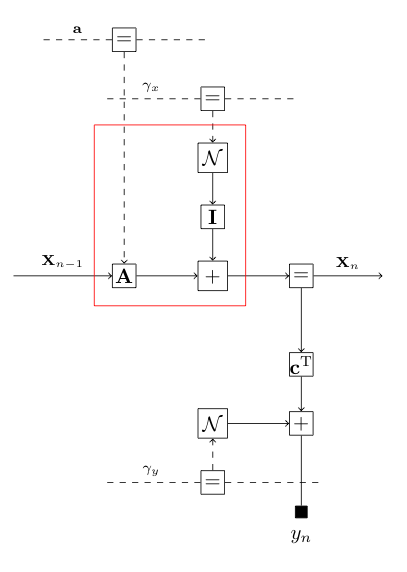

In [5]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma_x$ and the states $\mathbf{x}_n$, $\mathbf{x}_{n-1}$.

In [6]:
using ForneyLab
using Plots
import ARdata: use_data, generate_data
import LinearAlgebra: I, Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [9]:
# Define the order of AR model
ARorder = UInt16(10)
diagAR(dim) = Matrix{Float64}(I, dim, dim)
# Real state and preprocessing
x = use_data("/Users/albertpod/Documents/Julia/VariationalBayes/data/daily-minimum-temperatures.csv", ARorder)
[reverse!(x) for x in x]
# Noisy observations
y = [x .+ 0.1 for x in x]
y[1:5]

5-element Array{Array{Float64,1},1}:
 [20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9, 18.0, 20.8]
 [16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9, 18.0]
 [13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7, 18.9]
 [16.8, 13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9, 14.7]
 [21.6, 16.8, 13.4, 16.3, 20.1, 21.9, 17.5, 15.9, 15.9, 15.9]

In [10]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
Autoregression(x_t, x_t_prev, a, w)
@RV n ~ GaussianMeanVariance(0*rand(ARorder), 0.1*diagAR(ARorder))
@RV y_t = x_t + n

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(y_t, :y_t, dims=(ARorder,));

Variable(:y_t, Edges:
Edge belonging to variable y_t: ( addition_1.i[out] )----( placeholder_y_t.i[out] ).
)

In [11]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t_prev, x_t, w, ids=[:A, :X_t_prev, :X_t, :W])
# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
# Load algorithms
eval(Meta.parse(algo));

RecognitionFactor[RecognitionFactor(:A, Set(Variable[Variable(:a, Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]), Set(ForneyLab.Cluster[]), Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]
FactorNodes:
Autoregression with id autoregression_1
GaussianMeanPrecision with id gaussianmeanprecision_1

Symbol[:A, :agaussianmeanprecision_1bplaceholder_m_a_t, :agaussianmeanprecision_1bplaceholder_w_a_t]
Symbol[:X_t, :X_t_prev, :A, :W]
1.	NaiveVariationalRule{GaussianMeanPrecision} on Interface 1 (out) of GaussianMeanPrecision gaussianmeanprecision_1
2.	NaiveVariationalRule{Autoregression} on Interface 3 (a) of Autoregression autoregression_1

RecognitionFactor[RecognitionFactor(:X_t_prev, Set(Variable[Variable(:x_t_prev, Edges:
Edge belonging to variable x_t_prev: ( gaussianmeanprecision_2.i[out] )----( autoregression_1.i[x] ).
)]), Set(ForneyLab.Cluster[]), Edges:
Edge belonging t

In [13]:
# Define values for prior statistics
m_x_prev_0 = 100.0*rand(ARorder)
w_x_prev_0 = (tiny*diagAR(ARorder))
m_x_0 = 100.0*rand(ARorder)
w_x_0 = (tiny*diagAR(ARorder))
a_w_0 = 0
b_w_0 = 10
m_a_0 =  10.0*rand(ARorder)
w_a_0 = (1*diagAR(ARorder));

In [14]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [15]:
marginals = Dict()
n_its = 10
for t = 1:length(y)
    #println("Observation # ", t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    
    global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
           a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min
    
    for i = 1:n_its

        data = Dict(:y_t   => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :m_x_t => m_x_t_min,
                    :w_x_t => w_x_t_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)
        #display(data)
        stepA!(data, marginals)
        stepW!(data, marginals)
        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)

    end
    # Extract posterior statistics
    m_a[t] = unsafeMean(marginals[:a])
    w_a[t] = unsafePrecision(marginals[:a])
    m_x[t] = unsafeMean(marginals[:x_t])
    w_x[t] = unsafePrecision(marginals[:x_t])
    m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
    w_x_prev[t] = unsafePrecision(marginals[:x_t_prev])
    a_w[t] = marginals[:w].params[:a]
    b_w[t] = marginals[:w].params[:b]
    # Store to buffer
    m_a_t_min = m_a[t]
    w_a_t_min = w_a[t]
    m_x_t_prev_min = m_x_prev[t]
    w_x_t_prev_min = w_x_prev[t]
    m_x_t_min = m_x[t]
    w_x_t_min = w_x[t]
    a_w_t_min = a_w[t]
    b_w_t_min = b_w[t]
end

Observation # 1
Observation # 2
Observation # 3
Observation # 4
Observation # 5
Observation # 6
Observation # 7
Observation # 8
Observation # 9
Observation # 10
Observation # 11
Observation # 12
Observation # 13
Observation # 14
Observation # 15
Observation # 16
Observation # 17
Observation # 18
Observation # 19
Observation # 20
Observation # 21
Observation # 22
Observation # 23
Observation # 24
Observation # 25
Observation # 26
Observation # 27
Observation # 28
Observation # 29
Observation # 30
Observation # 31
Observation # 32
Observation # 33
Observation # 34
Observation # 35
Observation # 36
Observation # 37
Observation # 38
Observation # 39
Observation # 40
Observation # 41
Observation # 42
Observation # 43
Observation # 44
Observation # 45
Observation # 46
Observation # 47
Observation # 48
Observation # 49
Observation # 50
Observation # 51
Observation # 52
Observation # 53
Observation # 54
Observation # 55
Observation # 56
Observation # 57
Observation # 58
Observation # 59
Observ

Observation # 477
Observation # 478
Observation # 479
Observation # 480
Observation # 481
Observation # 482
Observation # 483
Observation # 484
Observation # 485
Observation # 486
Observation # 487
Observation # 488
Observation # 489
Observation # 490
Observation # 491
Observation # 492
Observation # 493
Observation # 494
Observation # 495
Observation # 496
Observation # 497
Observation # 498
Observation # 499
Observation # 500
Observation # 501
Observation # 502
Observation # 503
Observation # 504
Observation # 505
Observation # 506
Observation # 507
Observation # 508
Observation # 509
Observation # 510
Observation # 511
Observation # 512
Observation # 513
Observation # 514
Observation # 515
Observation # 516
Observation # 517
Observation # 518
Observation # 519
Observation # 520
Observation # 521
Observation # 522
Observation # 523
Observation # 524
Observation # 525
Observation # 526
Observation # 527
Observation # 528
Observation # 529
Observation # 530
Observation # 531
Observatio

Observation # 938
Observation # 939
Observation # 940
Observation # 941
Observation # 942
Observation # 943
Observation # 944
Observation # 945
Observation # 946
Observation # 947
Observation # 948
Observation # 949
Observation # 950
Observation # 951
Observation # 952
Observation # 953
Observation # 954
Observation # 955
Observation # 956
Observation # 957
Observation # 958
Observation # 959
Observation # 960
Observation # 961
Observation # 962
Observation # 963
Observation # 964
Observation # 965
Observation # 966
Observation # 967
Observation # 968
Observation # 969
Observation # 970
Observation # 971
Observation # 972
Observation # 973
Observation # 974
Observation # 975
Observation # 976
Observation # 977
Observation # 978
Observation # 979
Observation # 980
Observation # 981
Observation # 982
Observation # 983
Observation # 984
Observation # 985
Observation # 986
Observation # 987
Observation # 988
Observation # 989
Observation # 990
Observation # 991
Observation # 992
Observatio

Observation # 1405
Observation # 1406
Observation # 1407
Observation # 1408
Observation # 1409
Observation # 1410
Observation # 1411
Observation # 1412
Observation # 1413
Observation # 1414
Observation # 1415
Observation # 1416
Observation # 1417
Observation # 1418
Observation # 1419
Observation # 1420
Observation # 1421
Observation # 1422
Observation # 1423
Observation # 1424
Observation # 1425
Observation # 1426
Observation # 1427
Observation # 1428
Observation # 1429
Observation # 1430
Observation # 1431
Observation # 1432
Observation # 1433
Observation # 1434
Observation # 1435
Observation # 1436
Observation # 1437
Observation # 1438
Observation # 1439
Observation # 1440
Observation # 1441
Observation # 1442
Observation # 1443
Observation # 1444
Observation # 1445
Observation # 1446
Observation # 1447
Observation # 1448
Observation # 1449
Observation # 1450
Observation # 1451
Observation # 1452
Observation # 1453
Observation # 1454
Observation # 1455
Observation # 1456
Observation 

Observation # 1841
Observation # 1842
Observation # 1843
Observation # 1844
Observation # 1845
Observation # 1846
Observation # 1847
Observation # 1848
Observation # 1849
Observation # 1850
Observation # 1851
Observation # 1852
Observation # 1853
Observation # 1854
Observation # 1855
Observation # 1856
Observation # 1857
Observation # 1858
Observation # 1859
Observation # 1860
Observation # 1861
Observation # 1862
Observation # 1863
Observation # 1864
Observation # 1865
Observation # 1866
Observation # 1867
Observation # 1868
Observation # 1869
Observation # 1870
Observation # 1871
Observation # 1872
Observation # 1873
Observation # 1874
Observation # 1875
Observation # 1876
Observation # 1877
Observation # 1878
Observation # 1879
Observation # 1880
Observation # 1881
Observation # 1882
Observation # 1883
Observation # 1884
Observation # 1885
Observation # 1886
Observation # 1887
Observation # 1888
Observation # 1889
Observation # 1890
Observation # 1891
Observation # 1892
Observation 

Observation # 2305
Observation # 2306
Observation # 2307
Observation # 2308
Observation # 2309
Observation # 2310
Observation # 2311
Observation # 2312
Observation # 2313
Observation # 2314
Observation # 2315
Observation # 2316
Observation # 2317
Observation # 2318
Observation # 2319
Observation # 2320
Observation # 2321
Observation # 2322
Observation # 2323
Observation # 2324
Observation # 2325
Observation # 2326
Observation # 2327
Observation # 2328
Observation # 2329
Observation # 2330
Observation # 2331
Observation # 2332
Observation # 2333
Observation # 2334
Observation # 2335
Observation # 2336
Observation # 2337
Observation # 2338
Observation # 2339
Observation # 2340
Observation # 2341
Observation # 2342
Observation # 2343
Observation # 2344
Observation # 2345
Observation # 2346
Observation # 2347
Observation # 2348
Observation # 2349
Observation # 2350
Observation # 2351
Observation # 2352
Observation # 2353
Observation # 2354
Observation # 2355
Observation # 2356
Observation 

Observation # 2765
Observation # 2766
Observation # 2767
Observation # 2768
Observation # 2769
Observation # 2770
Observation # 2771
Observation # 2772
Observation # 2773
Observation # 2774
Observation # 2775
Observation # 2776
Observation # 2777
Observation # 2778
Observation # 2779
Observation # 2780
Observation # 2781
Observation # 2782
Observation # 2783
Observation # 2784
Observation # 2785
Observation # 2786
Observation # 2787
Observation # 2788
Observation # 2789
Observation # 2790
Observation # 2791
Observation # 2792
Observation # 2793
Observation # 2794
Observation # 2795
Observation # 2796
Observation # 2797
Observation # 2798
Observation # 2799
Observation # 2800
Observation # 2801
Observation # 2802
Observation # 2803
Observation # 2804
Observation # 2805
Observation # 2806
Observation # 2807
Observation # 2808
Observation # 2809
Observation # 2810
Observation # 2811
Observation # 2812
Observation # 2813
Observation # 2814
Observation # 2815
Observation # 2816
Observation 

Observation # 3201
Observation # 3202
Observation # 3203
Observation # 3204
Observation # 3205
Observation # 3206
Observation # 3207
Observation # 3208
Observation # 3209
Observation # 3210
Observation # 3211
Observation # 3212
Observation # 3213
Observation # 3214
Observation # 3215
Observation # 3216
Observation # 3217
Observation # 3218
Observation # 3219
Observation # 3220
Observation # 3221
Observation # 3222
Observation # 3223
Observation # 3224
Observation # 3225
Observation # 3226
Observation # 3227
Observation # 3228
Observation # 3229
Observation # 3230
Observation # 3231
Observation # 3232
Observation # 3233
Observation # 3234
Observation # 3235
Observation # 3236
Observation # 3237
Observation # 3238
Observation # 3239
Observation # 3240
Observation # 3241
Observation # 3242
Observation # 3243
Observation # 3244
Observation # 3245
Observation # 3246
Observation # 3247
Observation # 3248
Observation # 3249
Observation # 3250
Observation # 3251
Observation # 3252
Observation 

In [16]:
from = length(x) - 1000
predicted = [x[1] for x in m_x[1:end]]
noise = [y[1] for y in y[1:end]]
actual = [x[1] for x in x[1:end]]
mse = (sum((predicted - actual).^2))/length(predicted)

16.44413097937521

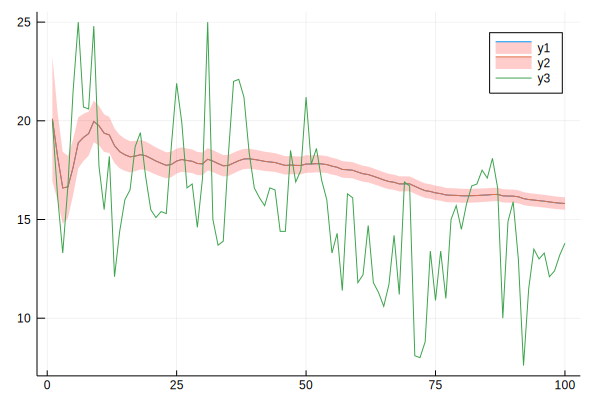

In [24]:
v_x = [v_x[1]^-1 for v_x in w_x] # variance
upto = 100#length(x)
scale = 10
plot([predicted[1:upto], predicted[1:upto]], fillrange=[predicted[1:upto]- scale .* sqrt.(v_x[1:upto]),predicted[1:upto]+ scale .* sqrt.(v_x[1:upto])],
     fillalpha = 0.2,
     fillcolor = :red,
     )
#plot!(noise[1:upto])
plot!(actual[1:upto])